# 🔮 DeepAR Forecasting Pipeline

**Ziel:** Lade trainiertes Model und erstelle probabilistische Forecasts

---

## 📋 Voraussetzungen

**⚠️ WICHTIG:** Zuerst muss `train_deepar.ipynb` ausgeführt werden!

Das Training erstellt:
- `models/deepar_retail_forecast.keras` - Trainiertes Model
- `models/scalers.pkl` - StandardScaler für X und y
- `models/config.json` - Model Configuration
- `models/metrics.json` - Performance Metriken

---

## 📋 Workflow

1. **Model laden** - Keras Model + Scaler + Config
2. **Daten laden** - Historische Verkaufsdaten
3. **Feature Engineering** - Wie im Training
4. **Forecast erstellen** - Für spezifischen Store/Product
5. **Visualisierung** - Mit Confidence Intervals
6. **Export** - Als CSV

**⏱️ Dauer:** Sekunden (kein Re-Training!)

---

## 1️⃣ Imports & Setup

In [2]:
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from datetime import datetime, timedelta

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# External Features
from external_features import ExternalFeatureOrchestrator

# Notebook Settings
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Pfade
MODEL_DIR = "models"
DATA_PATH = "retail_store_inventory.csv"

# External Features Orchestrator initialisieren
# Nutzt Holiday API (Nager.Date) + simulierte Bundesbank Daten
try:
    orchestrator = ExternalFeatureOrchestrator()
    print("✅ External Features Orchestrator bereit")
except Exception as e:
    print(f"⚠️  Orchestrator-Warnung: {e}")
    import traceback
    traceback.print_exc()
    orchestrator = None

print("✅ Imports erfolgreich")
print(f"TensorFlow Version: {tf.__version__}")

✅ External Features Orchestrator bereit
✅ Imports erfolgreich
TensorFlow Version: 2.19.1


## 2️⃣ Model & Artefakte laden

In [3]:
print("📦 Lade Model & Artefakte...")
print()

# Custom Loss für Model Loading
def gaussian_nll_loss(y_true, y_pred):
    """Gaussian Negative Log-Likelihood Loss"""
    mu = y_pred[:, 0]
    sigma = tf.nn.softplus(y_pred[:, 1]) + 1e-6
    loss = 0.5 * tf.math.log(2 * np.pi * sigma**2) + 0.5 * ((y_true - mu) ** 2) / (sigma**2)
    return tf.reduce_mean(loss)

# 1. Model laden
model_path = f'{MODEL_DIR}/deepar_retail_forecast.keras'
model = tf.keras.models.load_model(
    model_path,
    custom_objects={'gaussian_nll_loss': gaussian_nll_loss}
)
print(f"✅ Model:    {model_path}")

# 2. Scaler laden
scaler_path = f'{MODEL_DIR}/scalers.pkl'
with open(scaler_path, 'rb') as f:
    scalers = pickle.load(f)
    scaler_X = scalers['scaler_X']
    scaler_y = scalers['scaler_y']
print(f"✅ Scaler:   {scaler_path}")

# 3. Config laden
config_path = f'{MODEL_DIR}/config.json'
with open(config_path, 'r') as f:
    config = json.load(f)
    seq_length = config['seq_length']
    feature_cols = config['feature_cols']
print(f"✅ Config:   {config_path}")
print(f"   Sequenz:  {seq_length} Tage")
print(f"   Features: {len(feature_cols)}")

# 4. Metrics laden
metrics_path = f'{MODEL_DIR}/metrics.json'
with open(metrics_path, 'r') as f:
    metrics = json.load(f)
print(f"✅ Metrics:  {metrics_path}")

print()
print("="*70)
print("📊 MODEL PERFORMANCE")
print("="*70)
print(f"MAE:               {metrics['mae']:.2f}")
print(f"RMSE:              {metrics['rmse']:.2f}")
print(f"MAPE:              {metrics['mape']:.2f}%")
print(f"P10-P90 Coverage:  {metrics['p10_p90_coverage']:.1f}%")
print(f"Verbesserung:      {metrics['improvement']:.1f}% vs. Baseline")
print("="*70)

📦 Lade Model & Artefakte...

✅ Model:    models/deepar_retail_forecast.keras
✅ Scaler:   models/scalers.pkl
✅ Config:   models/config.json
   Sequenz:  30 Tage
   Features: 33
✅ Metrics:  models/metrics.json

📊 MODEL PERFORMANCE
MAE:               89.57
RMSE:              109.73
MAPE:              5850509551.92%
P10-P90 Coverage:  44.2%
Verbesserung:      0.2% vs. Baseline
✅ Model:    models/deepar_retail_forecast.keras
✅ Scaler:   models/scalers.pkl
✅ Config:   models/config.json
   Sequenz:  30 Tage
   Features: 33
✅ Metrics:  models/metrics.json

📊 MODEL PERFORMANCE
MAE:               89.57
RMSE:              109.73
MAPE:              5850509551.92%
P10-P90 Coverage:  44.2%
Verbesserung:      0.2% vs. Baseline


## 3️⃣ Daten laden

In [4]:
print("📊 Lade Daten...")
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

print(f"✅ {len(df):,} Datenpunkte geladen")
print(f"✅ Zeitraum: {df['Date'].min()} bis {df['Date'].max()}")
print(f"✅ Stores: {df['Store ID'].nunique()}")
print(f"✅ Products: {df['Product ID'].nunique()}")
print()

# Übersicht
stores = sorted(df['Store ID'].unique())
products = sorted(df['Product ID'].unique())

print(f"📊 Verfügbare Stores:   {len(stores)} ({min(stores)} - {max(stores)})")
print(f"📦 Verfügbare Products: {len(products)} ({min(products)} - {max(products)})")
print()
df.head()

📊 Lade Daten...
✅ 73,100 Datenpunkte geladen
✅ Zeitraum: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
✅ Stores: 5
✅ Products: 20

📊 Verfügbare Stores:   5 (S001 - S005)
📦 Verfügbare Products: 20 (P0001 - P0020)



,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,Cloudy,0,30.89,Spring
2,2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,Rainy,0,58.22,Winter
3,2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,Cloudy,1,75.99,Winter
4,2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,Sunny,1,29.40,Winter


## 4️⃣ Feature Engineering Funktionen

In [5]:
def create_features(df, target_col='Units Sold', lag_periods=[1, 7, 30], rolling_windows=[7, 30]):
    """Erstellt Features wie im Training + One-Hot Encoding"""
    df = df.copy()
    
    # One-Hot Encoding für kategorische Variablen (nur wenn noch nicht encodiert)
    categorical_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
    existing_categorical = [col for col in categorical_cols if col in df.columns]
    
    if existing_categorical:
        df = pd.get_dummies(df, columns=existing_categorical, drop_first=True, dtype=int)
    
    # Datum Features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    
    # Lag Features
    for lag in lag_periods:
        df[f'{target_col}_lag_{lag}'] = df.groupby(['Store ID', 'Product ID'])[target_col].shift(lag)
    
    # Rolling Features
    for window in rolling_windows:
        # Rolling Mean
        rolling_mean = df.groupby(['Store ID', 'Product ID'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{target_col}_rolling_mean_{window}'] = rolling_mean
        
        # Rolling Std
        rolling_std = df.groupby(['Store ID', 'Product ID'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        df[f'{target_col}_rolling_std_{window}'] = rolling_std
    
    return df

print("✅ Feature Engineering Funktion definiert (inkl. One-Hot Encoding)")

✅ Feature Engineering Funktion definiert (inkl. One-Hot Encoding)


## 5️⃣ Forecast Funktionen

In [6]:
def get_future_context(next_date, df_historical, orchestrator=None):
    """
    Holt echte zukünftige Features für ein Datum.
    
    Verwendet:
    - External APIs (Feiertage, Wirtschaftsdaten)
    - Seasonalität aus Datum
    - Weather Proxy via Seasonalität
    """
    # 1. Feiertag-Info aus API (mit besserer Fehlerbehandlung)
    is_holiday = 0
    if orchestrator is not None:
        try:
            ext_features = orchestrator.get_features_for_date(next_date)
            is_holiday = int(ext_features.get('is_holiday', 0))
        except Exception as e:
            # Stiller Fallback - keine Warnung für jeden Tag
            is_holiday = 0
    
    # 2. Seasonalität aus Datum ableiten
    month = next_date.month
    if month in [12, 1, 2]:
        seasonality = 'Winter'
    elif month in [3, 4, 5]:
        seasonality = 'Spring'
    elif month in [6, 7, 8]:
        seasonality = 'Summer'
    else:
        seasonality = 'Autumn'
    
    # 3. Weather Proxy: Nutze saisonale Patterns aus historischen Daten
    # Finde typisches Wetter für diese Saison und Monat
    historical_same_season = df_historical[
        (df_historical['Date'].dt.month == month)
    ]
    
    if len(historical_same_season) > 0:
        # Häufigstes Wetter in diesem Monat (historisch)
        weather = historical_same_season['Weather Condition'].mode().iloc[0] if len(historical_same_season) > 0 else 'Sunny'
        region = historical_same_season['Region'].mode().iloc[0] if len(historical_same_season) > 0 else historical_same_season['Region'].iloc[-1]
        category = historical_same_season['Category'].mode().iloc[0] if len(historical_same_season) > 0 else historical_same_season['Category'].iloc[-1]
    else:
        # Fallback zu letzten bekannten Werten
        weather = df_historical['Weather Condition'].iloc[-1]
        region = df_historical['Region'].iloc[-1]
        category = df_historical['Category'].iloc[-1]
    
    return {
        'Holiday/Promotion': is_holiday,
        'Seasonality': seasonality,
        'Weather Condition': weather,
        'Region': region,
        'Category': category
    }


def predict_for_store_product(store_id, product_id, days_ahead, 
                              model, df, feature_cols, scaler_X, scaler_y, seq_length,
                              visualize=True, use_external_features=True, orchestrator=None):
    """
    Erstellt Forecast für spezifischen Store/Product
    
    Parameters:
    -----------
    store_id : str
        Store ID
    product_id : str
        Product ID
    days_ahead : int
        Anzahl Tage in die Zukunft
    model : Keras Model
        Trainiertes Model
    df : DataFrame
        Historische Daten
    feature_cols : list
        Feature-Spalten
    scaler_X, scaler_y : StandardScaler
        Scaler
    seq_length : int
        Sequenzlänge
    visualize : bool
        Visualisierung erstellen?
    use_external_features : bool
        Nutze External APIs für zukünftige Features?
    orchestrator : ExternalFeatureOrchestrator
        Optional: Orchestrator für externe Features
    
    Returns:
    --------
    DataFrame : Forecast mit Dates und Confidence Intervals
    """
    # Filter für Store/Product
    df_filtered = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)].copy()
    
    if len(df_filtered) < seq_length:
        print(f"❌ Nicht genug Daten: {len(df_filtered)} Tage (brauche {seq_length})")
        return None
    
    print(f"📊 Store {store_id}, Product {product_id}: {len(df_filtered)} historische Tage")
    
    # Features erstellen
    df_with_features = create_features(df_filtered)
    df_with_features = df_with_features.dropna()
    
    print(f"📊 Nach Feature Engineering: {len(df_with_features)} Zeilen (brauche {seq_length})")
    
    if len(df_with_features) < seq_length:
        print(f"❌ Nach Feature Engineering: Nur {len(df_with_features)} Tage")
        return None
    
    # Multi-Step Forecast
    forecasts = []
    current_data = df_with_features.copy()
    last_date = current_data['Date'].max()
    
    # Spalten die für neue Rows verwendet werden
    base_cols = ['Inventory Level', 'Units Ordered', 'Demand Forecast', 
                 'Price', 'Discount', 'Competitor Pricing']
    
    # WICHTIG: Wochentag-Information zum Filtern hinzufügen
    df_filtered_with_weekday = df_filtered.copy()
    df_filtered_with_weekday['Weekday'] = df_filtered_with_weekday['Date'].dt.weekday
    
    # Alle One-Hot Spalten im aktuellen DataFrame
    all_onehot_cols = [col for col in current_data.columns 
                       if col.startswith(('Category_', 'Region_', 'Weather Condition_', 'Seasonality_'))]
    
    # WICHTIG: Sicherstellen, dass alle erwarteten Features existieren
    # Fehlende One-Hot Spalten mit 0 füllen
    expected_onehot_cols = [col for col in feature_cols 
                            if col.startswith(('Category_', 'Region_', 'Weather Condition_', 'Seasonality_'))]
    for col in expected_onehot_cols:
        if col not in current_data.columns:
            current_data[col] = 0
    
    print(f"⏳ Erstelle {days_ahead}-Tage Forecast...")
    if use_external_features:
        print(f"📡 Nutze External APIs für zukünftige Features (Feiertage, Seasonalität, Wetter-Proxy)")
    else:
        print(f"📊 Nutze Wochentag-spezifische Patterns aus historischen Daten")
    
    for day in range(1, days_ahead + 1):
        # Letzte seq_length Tage
        X_input = current_data[feature_cols].values[-seq_length:].reshape(1, seq_length, -1)
        
        # Skalieren & Predict
        X_scaled = scaler_X.transform(X_input.reshape(-1, X_input.shape[-1])).reshape(X_input.shape)
        pred = model.predict(X_scaled, verbose=0)
        
        mu = pred[0, 0]
        sigma = np.abs(pred[0, 1])
        
        # Zurück-transformieren
        mu_original = scaler_y.inverse_transform([[mu]])[0, 0]
        sigma_original = sigma * scaler_y.scale_[0]
        
        # Percentile
        p10 = max(0, mu_original - 1.28 * sigma_original)
        p50 = max(0, mu_original)
        p90 = max(0, mu_original + 1.28 * sigma_original)
        
        # Nächstes Datum
        next_date = last_date + timedelta(days=day)
        
        forecasts.append({
            'Date': next_date,
            'Day_Ahead': day,
            'Forecast_P10': p10,
            'Forecast_P50': p50,
            'Forecast_P90': p90,
            'Uncertainty': sigma_original
        })
        
        # Update current_data für nächste Iteration (Rolling Forecast)
        if use_external_features:
            # Hole echte zukünftige Features
            future_context = get_future_context(next_date, df_filtered, orchestrator)
            
            # Numerische Werte: Durchschnitt der letzten 7 Tage
            avg_values = current_data[base_cols].tail(7).mean().to_dict()
            
            new_row = {
                'Date': next_date,
                'Store ID': store_id,
                'Product ID': product_id,
                'Units Sold': p50,
                **avg_values,
                **future_context  # Echte zukünftige Features!
            }
        else:
            # Fallback: Verwende Wochentag-spezifische Patterns aus historischen Daten
            next_weekday = next_date.weekday()  # 0=Montag, 6=Sonntag
            
            # Finde alle historischen Daten für den gleichen Wochentag
            historical_same_weekday = df_filtered_with_weekday[
                df_filtered_with_weekday['Weekday'] == next_weekday
            ]
            
            # NUMERISCHE Werte: Durchschnitt für diesen Wochentag
            if len(historical_same_weekday) >= 3:
                avg_values = historical_same_weekday[base_cols].tail(20).mean().to_dict()
            else:
                # Fallback: Letzte 7 Tage
                avg_values = df_filtered[base_cols].tail(7).mean().to_dict()
            
            # KATEGORISCHE Werte: Modus für diesen Wochentag
            categorical_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
            categorical_values = {}
            
            if len(historical_same_weekday) >= 3:
                for col in categorical_cols:
                    if col in df_filtered.columns:
                        mode_result = historical_same_weekday[col].mode()
                        categorical_values[col] = mode_result.iloc[0] if len(mode_result) > 0 else df_filtered[col].iloc[-1]
            else:
                # Fallback: Nutze letzte 7 Tage
                for col in categorical_cols:
                    if col in df_filtered.columns:
                        mode_result = df_filtered[col].tail(7).mode()
                        categorical_values[col] = mode_result.iloc[0] if len(mode_result) > 0 else df_filtered[col].iloc[-1]
            
            new_row = {
                'Date': next_date,
                'Store ID': store_id,
                'Product ID': product_id,
                'Units Sold': p50,
                **avg_values,  # Wochentag-spezifische numerische Werte!
                **categorical_values  # Wochentag-spezifische kategorische Werte!
            }
        
        new_df = pd.DataFrame([new_row])
        current_data = pd.concat([current_data, new_df], ignore_index=True)
        current_data = create_features(current_data)
        
        # Sicherstellen, dass alle One-Hot Spalten existieren (fülle fehlende mit 0)
        for col in all_onehot_cols:
            if col not in current_data.columns:
                current_data[col] = 0
        
        # NUR die neuen Rows (mit NaNs) entfernen, NICHT alle historischen!
        # Behalte nur die letzten Zeilen, die vollständige Features haben
        if current_data.iloc[-1].isna().any():
            current_data = current_data.iloc[:-1]
    
    forecast_df = pd.DataFrame(forecasts)
    print(f"✅ Forecast erstellt!")
    
    # Visualisierung
    if visualize:
        plt.figure(figsize=(16, 6))
        
        # Historische Daten (letzte 60 Tage)
        hist_df = df_filtered.tail(60)
        plt.plot(hist_df['Date'], hist_df['Units Sold'], 
                label='Historical', color='black', linewidth=2)
        
        # Forecast
        plt.plot(forecast_df['Date'], forecast_df['Forecast_P50'], 
                label='Forecast (P50)', color='blue', linewidth=2)
        plt.fill_between(forecast_df['Date'], 
                        forecast_df['Forecast_P10'], 
                        forecast_df['Forecast_P90'],
                        alpha=0.3, color='blue', label='80% Confidence Interval')
        
        plt.axvline(x=last_date, color='red', linestyle='--', linewidth=1.5, 
                   label='Forecast Start')
        
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Units Sold', fontsize=12)
        plt.title(f'Forecast: Store {store_id}, Product {product_id} ({days_ahead} Days)', 
                 fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Speichern
        output_path = f'forecasts/forecast_store{store_id}_product{product_id}.png'
        Path('forecasts').mkdir(exist_ok=True)
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"✅ Visualisierung: {output_path}")
        plt.show()
    
    return forecast_df

print("✅ Forecast Funktion definiert (mit External Features Support)")

✅ Forecast Funktion definiert (mit External Features Support)


## 6️⃣ Forecast erstellen

**Wähle Store & Product ID:**

🎯 FORECAST CONFIGURATION
Store ID:      S001
Product ID:    P0001
Days Ahead:    30
External APIs: ✅ Aktiv (echte Variation)

📊 Store S001, Product P0001: 731 historische Tage
📊 Nach Feature Engineering: 701 Zeilen (brauche 30)
⏳ Erstelle 30-Tage Forecast...
📡 Nutze External APIs für zukünftige Features (Feiertage, Seasonalität, Wetter-Proxy)
⚠️  Cache read failed: Expecting value: line 3 column 13 (char 18)
⚠️  Using realistic simulated interest rate data (Bundesbank API unstable)
⚠️  Cache read failed: Expecting value: line 3 column 13 (char 18)
⚠️  Using realistic simulated interest rate data (Bundesbank API unstable)
⚠️  Cache read failed: Expecting value: line 3 column 13 (char 18)
⚠️  Using realistic simulated interest rate data (Bundesbank API unstable)
⚠️  Cache read failed: Expecting value: line 3 column 13 (char 18)
⚠️  Using realistic simulated interest rate data (Bundesbank API unstable)
⚠️  Cache read failed: Expecting value: line 3 column 13 (char 18)
⚠️  Using realistic 

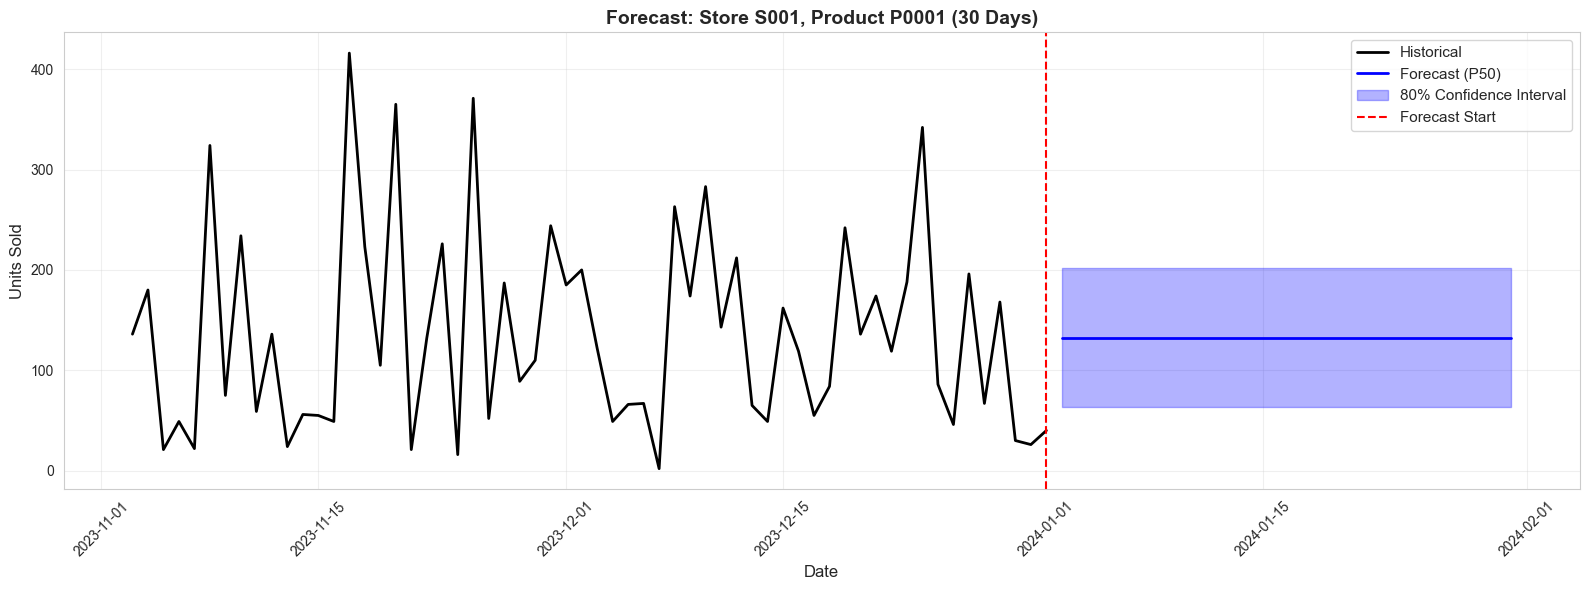

In [7]:
# ============================================
# 🎯 HIER ANPASSEN!
# ============================================

STORE_ID = 'S001'      # Store ID (z.B. 'S001', 'S002', ...)
PRODUCT_ID = 'P0001'   # Product ID (z.B. 'P0001', 'P0002', ...)
DAYS_AHEAD = 30        # Anzahl Tage voraussagen

USE_EXTERNAL_FEATURES = True  # True = Externe APIs mit Variation, False = Wochentag-Patterns (flach)

# ============================================

print("="*70)
print(f"🎯 FORECAST CONFIGURATION")
print("="*70)
print(f"Store ID:      {STORE_ID}")
print(f"Product ID:    {PRODUCT_ID}")
print(f"Days Ahead:    {DAYS_AHEAD}")
print(f"External APIs: {'✅ Aktiv (echte Variation)' if USE_EXTERNAL_FEATURES else '❌ Deaktiviert (Wochentag-Patterns)'}")
print("="*70)
print()

# Forecast erstellen
forecast_df = predict_for_store_product(
    STORE_ID, PRODUCT_ID, DAYS_AHEAD,
    model, df, feature_cols, scaler_X, scaler_y, seq_length,
    visualize=True,
    use_external_features=USE_EXTERNAL_FEATURES,  # Steuerung hier!
    orchestrator=orchestrator  # Orchestrator übergeben!
)

## 7️⃣ Forecast Ergebnisse anzeigen

In [8]:
if forecast_df is not None:
    print("="*70)
    print("📊 FORECAST RESULTS")
    print("="*70)
    print()
    display(forecast_df)
    print()
    print("💡 Interpretation:")
    print("   P10 (10th Percentile):  Pessimistisch (10% Chance schlechter)")
    print("   P50 (Median):            Erwarteter Wert (beste Schätzung)")
    print("   P90 (90th Percentile):  Optimistisch (10% Chance besser)")
    print("   Uncertainty:             Standardabweichung der Vorhersage")
    print("="*70)
else:
    print("❌ Kein Forecast erstellt (siehe Fehler oben)")

📊 FORECAST RESULTS



,Date,Day_Ahead,Forecast_P10,Forecast_P50,Forecast_P90,Uncertainty
0,2024-01-02,1,63.020738,132.596042,202.171346,54.355706
1,2024-01-03,2,63.020738,132.596042,202.171346,54.355706
2,2024-01-04,3,63.020738,132.596042,202.171346,54.355706
3,2024-01-05,4,63.020738,132.596042,202.171346,54.355706
4,2024-01-06,5,63.020738,132.596042,202.171346,54.355706
5,2024-01-07,6,63.020738,132.596042,202.171346,54.355706
6,2024-01-08,7,63.020738,132.596042,202.171346,54.355706
7,2024-01-09,8,63.020738,132.596042,202.171346,54.355706
8,2024-01-10,9,63.020738,132.596042,202.171346,54.355706
9,2024-01-11,10,63.020738,132.596042,202.171346,54.355706



💡 Interpretation:
   P10 (10th Percentile):  Pessimistisch (10% Chance schlechter)
   P50 (Median):            Erwarteter Wert (beste Schätzung)
   P90 (90th Percentile):  Optimistisch (10% Chance besser)
   Uncertainty:             Standardabweichung der Vorhersage


## 8️⃣ Forecast als CSV exportieren

In [ ]:
if forecast_df is not None:
    # CSV Export
    output_path = f'forecasts/forecast_store{STORE_ID}_product{PRODUCT_ID}.csv'
    Path('forecasts').mkdir(exist_ok=True)
    forecast_df.to_csv(output_path, index=False)
    
    print(f"✅ Forecast exportiert: {output_path}")
    print()
    print("📦 Exportierte Dateien:")
    print(f"   • {output_path}")
    print(f"   • forecasts/forecast_store{STORE_ID}_product{PRODUCT_ID}.png")
else:
    print("❌ Kein Forecast zum Exportieren")

✅ Forecast exportiert: forecasts/forecast_storeS001_productP0001.csv

📦 Exportierte Dateien:
   • forecasts/forecast_storeS001_productP0001.csv
   • forecasts/forecast_storeS001_productP0001.png


## 9️⃣ Batch Forecasts (Optional)

**Forecasts für mehrere Store/Product Kombinationen:**

In [ ]:
# Beispiel: Forecasts für mehrere Kombinationen
# batch_config = [
#     {'store': 'S001', 'product': 'P0001', 'days': 30},
#     {'store': 'S001', 'product': 'P0002', 'days': 30},
#     {'store': 'S002', 'product': 'P0005', 'days': 14},
#     # Füge weitere hinzu...
# ]

# print("🔮 Batch Forecasting...")
# print(f"Anzahl: {len(batch_config)} Kombinationen")
# print()

# batch_results = []

# for i, cfg in enumerate(batch_config, 1):
#     print(f"\n[{i}/{len(batch_config)}] Store {cfg['store']}, Product {cfg['product']}")
#     print("-" * 70)
    
#     forecast = predict_for_store_product(
#         cfg['store'], cfg['product'], cfg['days'],
#         model, df, feature_cols, scaler_X, scaler_y, seq_length,
#         visualize=False  # Keine Plots für Batch
#     )
    
#     if forecast is not None:
#         forecast['Store_ID'] = cfg['store']
#         forecast['Product_ID'] = cfg['product']
#         batch_results.append(forecast)
        
#         # Export
#         output_path = f"forecasts/batch_store{cfg['store']}_product{cfg['product']}.csv"
#         forecast.to_csv(output_path, index=False)
#         print(f"✅ Exportiert: {output_path}")

# print()
# print("="*70)
# print(f"✅ Batch Forecasting abgeschlossen: {len(batch_results)}/{len(batch_config)}")
# print("="*70)

## 🔟 Zusammenfassung

### ✅ Was wurde gemacht?

1. **Model geladen** - Trainiertes DeepAR Model
2. **Forecast erstellt** - Probabilistische Vorhersagen (P10, P50, P90)
3. **Visualisiert** - Mit 80% Confidence Intervals
4. **Exportiert** - Als CSV

### 📊 Output Files

```
forecasts/
├── forecast_store{STORE_ID}_product{PRODUCT_ID}.png   # Visualisierung
└── forecast_store{STORE_ID}_product{PRODUCT_ID}.csv   # CSV Export
```

### 🔄 Nächste Schritte

1. **Andere Store/Product?** → Ändere `STORE_ID` und `PRODUCT_ID` in Zelle 6
2. **Mehr Tage?** → Ändere `DAYS_AHEAD` in Zelle 6
3. **Batch Forecasts?** → Nutze Zelle 9
4. **Neues Training?** → Zurück zu `train_deepar.ipynb`

---